In [139]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

from scipy.special import softmax

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance

import optuna

In [50]:
df_matches = pd.read_csv("matches.csv")
df_matches["leagueSeason"].value_counts()

leagueSeason
2010    306
2011    306
2012    306
2013    306
2014    306
2015    306
2016    306
2017    306
2018    306
2019    306
2020    306
2021    306
2022    306
2023    306
Name: count, dtype: int64

In [110]:
def get_splits_by(df, column="leagueSeason", start=1):
    df = df.reset_index()
    splits = []
    split_test_seasons = []
    values_unique = df[column].unique()
    values_unique.sort()
    min_value = values_unique[0]
    for i in range(start, len(values_unique)):
        test_value = values_unique[i]
        train_rows = df[(df[column] >= min_value) & (df[column] < test_value)]
        test_rows = df[df[column] == test_value]
        splits.append((train_rows.index, test_rows.index))
        split_test_seasons.append(values_unique[i])
    return splits

def to_labels(df):
    return np.array(df[["team1Goals", "team2Goals"]].values)

In [18]:
def compute_kicktipp_score(predictions, y):
    predictions_draw = predictions[:, 0] == predictions[:, 1]
    predictions_win1 = predictions[:, 0] > predictions[:, 1]
    predictions_win2 = predictions[:, 0] < predictions[:, 1]
    predictions_diff = predictions[:, 0] - predictions[:, 1]
    y_draw = y[:, 0] == y[:, 1]
    y_win1 = y[:, 0] > y[:, 1]
    y_win2 = y[:, 0] < y[:, 1]
    y_diff = y[:, 0] - y[:, 1]

    correct_result = (predictions[:, 0] == y[:, 0]) & (predictions[:, 1] == y[:, 1])
    correct_result_win = (correct_result & y_win1) | (correct_result & y_win2)
    correct_result_draw = correct_result & (~correct_result_win)
    correct_tendency_win = (predictions_win1 & y_win1) | (predictions_win2 & y_win2)
    correct_tendency_draw = (predictions_draw & y_draw)
    correct_diff_win = (predictions_diff == y_diff) & correct_tendency_win

    score = 0
    score += np.count_nonzero(correct_result) * 4
    score += np.count_nonzero(correct_diff_win & (~correct_result)) * 3
    score += np.count_nonzero(correct_tendency_draw & (~correct_result_draw)) * 2
    score += np.count_nonzero(correct_tendency_win & (~correct_result_win) & ~(correct_diff_win)) * 2
    return score

def kicktipp_scoring(estimator, X, y):
    predictions = estimator.predict(X)
    return compute_kicktipp_score(predictions, y)

assert compute_kicktipp_score(np.array([[0, 0], [1, 1]]), np.array([[0, 0], [1, 1]])) == 8
assert compute_kicktipp_score(np.array([[0, 0], [2, 1]]), np.array([[0, 0], [1, 1]])) == 4
assert compute_kicktipp_score(np.array([[0, 0], [1, 1]]), np.array([[0, 0], [1, 2]])) == 4
assert compute_kicktipp_score(np.array([[0, 0], [2, 1]]), np.array([[0, 0], [1, 0]])) == 7
assert compute_kicktipp_score(np.array([[1, 0], [2, 1]]), np.array([[0, 0], [1, 0]])) == 3
assert compute_kicktipp_score(np.array([[1, 3], [1, 1], [3, 0], [1, 1], [0, 2], [1, 1], [3, 1], [1, 3], [1, 1]]), np.array([[2, 3], [3, 2], [1, 0], [2, 2], [3, 1], [1, 1], [2, 0], [2, 3], [0, 2]])) == 15


## Baseline Models

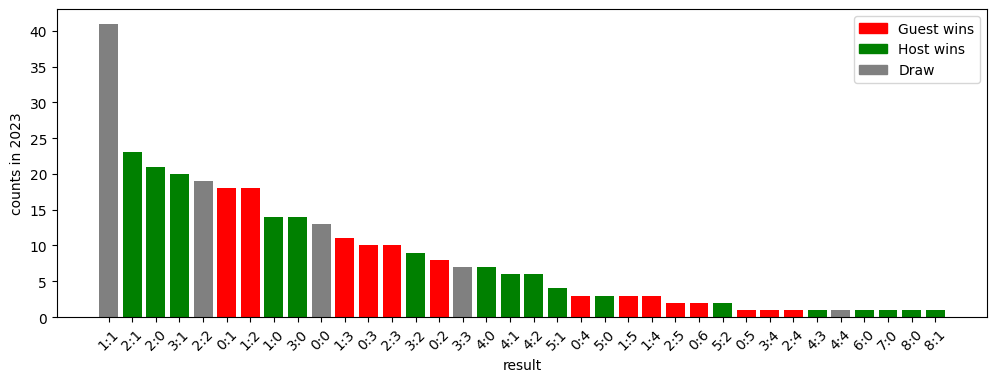

In [60]:
def visualize_results():
    splits = get_splits_by(df_matches)
    split = splits[-1]
    train, test = df_matches.iloc[split[0]], df_matches.iloc[split[1]]
    labels = to_labels(df_matches)
    y_train, y_test = labels[split[0]], labels[split[1]]

    y_test_encoded = [f"{r[0]}:{r[1]}" for r in y_test]
    results, counts = np.unique(y_test_encoded, return_counts=True)
    sort = np.argsort(-counts)
    counts = counts[sort]
    results = results[sort]
    tendency = [1] * len(results)
    for i, res in enumerate(results):
        goals = res.split(":")
        if goals[0] > goals[1]:
            tendency[i] = 0
        elif goals[0] < goals[1]:
            tendency[i] = 2

    y_test_colors = [["green", "gray", "red"][r] for r in tendency]
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.bar(range(len(results)), counts, color=y_test_colors)
    ax.set_xlabel("result")
    ax.set_ylabel(f"counts in {test.iloc[0]["leagueSeason"]}")
    ax.set_xticks(range(len(results)), results, rotation=45)

    red_patch = mpatches.Patch(color='red', label='Guest wins')
    green_patch = mpatches.Patch(color='green', label='Host wins')
    gray_patch = mpatches.Patch(color='gray', label='Draw')
    ax.legend(handles=[red_patch, green_patch, gray_patch])

visualize_results()

In [133]:
class StaticEstimator(BaseEstimator):
    def __init__(self, result) -> None:
        super().__init__()
        self.result = result

    def fit(self, X, y):
        pass

    def predict(self, X):
        results = np.zeros((len(X), 2))
        results[:] = self.result
        return results

def find_latest_match(df_matches, short1, short2):
    mask = (df_matches["team1Short"] == short1) & (df_matches["team2Short"] == short2)
    mask = mask | (df_matches["team2Short"] == short1) & (df_matches["team1Short"] == short2)
    masked = df_matches.loc[mask, "date"]
    if len(masked) == 0:
        return None
    latest_match = masked.idxmax()
    return df_matches.iloc[latest_match]


def get_teams_of_latest_season(df_matches):
    season = df_matches["leagueSeason"].max()
    return df_matches.loc[df_matches["leagueSeason"] == season, "team1Short"].unique()

class LatestResultEstimator(BaseEstimator):

    def __init__(self) -> None:
        super().__init__()

    def fit(self, X, y):
        self.X_train = X
        self.teams_of_latest_season = get_teams_of_latest_season(X)

    def predict(self, X: pd.DataFrame):
        results = []
        for index, row in X.iterrows():
            team1 = row["team1Short"]
            team2 = row["team2Short"]
            latest_match = find_latest_match(self.X_train, team1, team2)
            if latest_match is None:
                if (team1 not in self.teams_of_latest_season) and (team2 not in self.teams_of_latest_season):
                    results.append([0, 0])
                elif team1 in self.teams_of_latest_season:
                    results.append([1, 0])
                elif team2 in self.teams_of_latest_season:
                    results.append([0, 1])
                else:
                    raise ValueError(f"A match between {team1} and {team2} must exist")
            else:
                results.append(to_labels(latest_match))

        return np.array(results)

0:0: 187.69 +- 17.45
1:1: 223.38 +- 17.01
1:0: 354.46 +- 25.95
0:1: 245.77 +- 20.83
Latest result: 289.77 +- 17.71


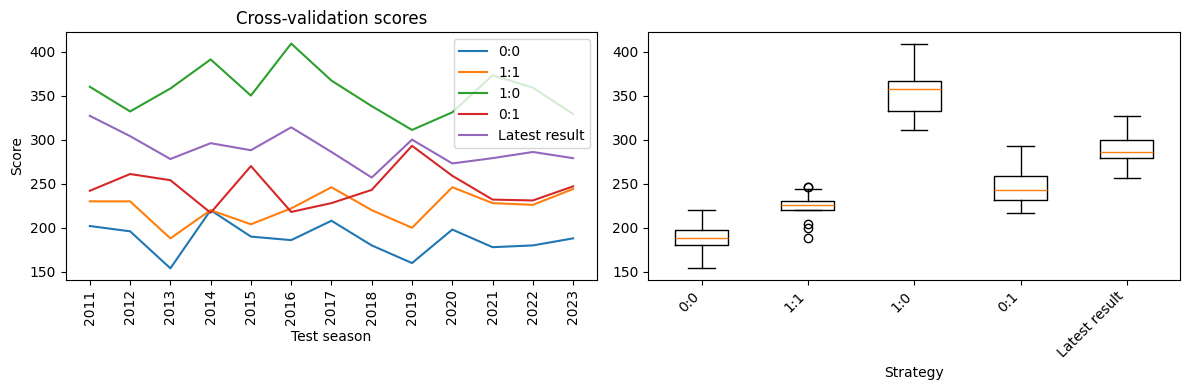

In [113]:
def evaluate_simple_models(scoring):
    splits = get_splits_by(df_matches)
    static_results = [[0, 0], [1, 1], [1, 0], [0, 1]]
    static_result_scores = []
    for result in static_results:
        scores = cross_val_score(StaticEstimator(result), df_matches, to_labels(df_matches), cv=splits, scoring=scoring)
        static_result_scores.append(scores)

    static_result_scores = np.array(static_result_scores)

    latest_result_scores = cross_val_score(LatestResultEstimator(), df_matches, to_labels(df_matches), cv=splits, scoring=scoring)

    all_scores = np.vstack((static_result_scores, latest_result_scores))
    labels = [f"{res[0]}:{res[1]}" for res in static_results] + ["Latest result"]
    for score, label in zip(all_scores, labels):
        print(f"{label}: {score.mean():.2f} +- {score.std():.2f}")

    fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
    split_test_seasons = [df_matches.iloc[split[1][0]]["leagueSeason"] for  split in splits]
    axs[0].plot(all_scores.T, label=labels)
    axs[0].set_xticks(range(len(split_test_seasons)), split_test_seasons, rotation=90, ha='center')
    axs[0].set_xlabel("Test season")
    axs[0].set_ylabel("Score")
    axs[0].legend()
    axs[0].set_title("Cross-validation scores")

    axs[1].boxplot(all_scores.T)
    axs[1].set_xlabel("Strategy")
    axs[1].set_xticks(range(1, len(labels) +1), labels, rotation=45, ha="right")
    fig.tight_layout()

evaluate_simple_models(scoring=kicktipp_scoring)

## Proxy loss

0:0: 1.80 +- 0.11
1:1: 1.60 +- 0.10
1:0: 1.76 +- 0.13
0:1: 2.03 +- 0.09
Latest result: 1.69 +- 0.39


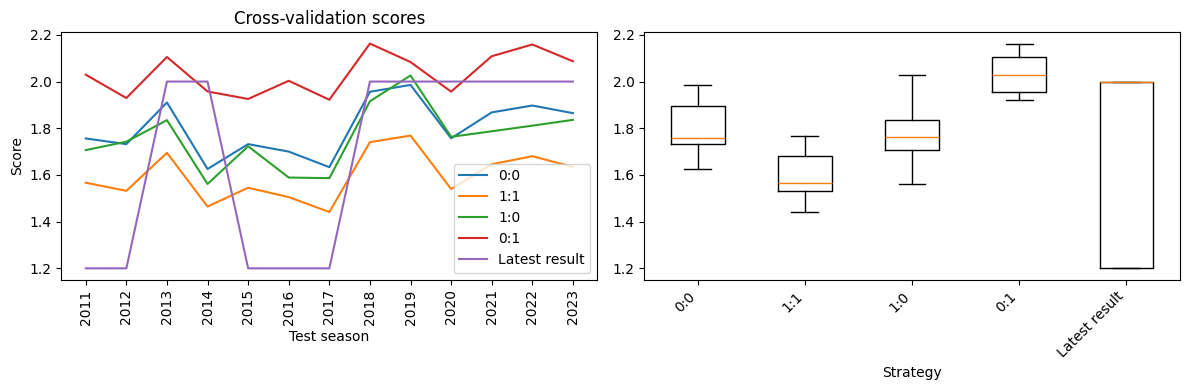

In [135]:
def proxy_score(y_pred, y_true, alpha=0.8):
    assert y_pred.shape == y_true.shape
    diff_pred = y_pred[:, 0] - y_pred[:, 1]
    diff_true = y_true[:, 0] - y_true[:, 1]
    diff_abs = np.mean(np.abs((diff_pred - diff_true)))
    home_abs = np.mean(np.abs(y_pred[:, 0] - y_true[:, 0]))
    guest_abs = np.mean(np.abs(y_pred[:, 1] - y_true[:, 1]))
    return alpha * diff_abs + (1-alpha) * (home_abs + guest_abs)

def proxy_scoring(estimator, X, y):
    predictions = estimator.predict(X)
    return proxy_score(predictions, y)

evaluate_simple_models(scoring=proxy_scoring)

# Matches with team context

In [74]:
df_full = pd.read_csv("matches_with_context.csv", index_col="id")
df_full.tail()

,date,matchDay,matchDayID,leagueID,leagueName,leagueSeason,team1ID,team1Name,team1Short,team2ID,...,guest_opponentGoals,guest_points,guest_won,guest_draw_mean_previous,guest_goalDiff_mean_previous,guest_goals_mean_previous,guest_lost_mean_previous,guest_opponentGoals_mean_previous,guest_points_mean_previous,guest_won_mean_previous
id,,,,,,,,,,,,,,,,,,,,,
66932,2024-05-18T13:30:00Z,34. Spieltag,34,4608,1. Fußball-Bundesliga 2023/2024,2023,131,VfL Wolfsburg,Wolfsburg,81,...,55.0,46.0,12.0,8.083333,-5.166667,45.416667,14.166667,50.583333,43.333333,11.750000
66933,2024-05-18T13:30:00Z,34. Spieltag,34,4608,1. Fußball-Bundesliga 2023/2024,2023,175,TSG 1899 Hoffenheim,Hoffenheim,40,...,38.0,71.0,21.0,4.833333,61.833333,89.583333,3.916667,27.750000,80.583333,25.250000
66934,2024-05-18T13:30:00Z,34. Spieltag,34,4608,1. Fußball-Bundesliga 2023/2024,2023,134,Werder Bremen,Bremen,129,...,72.0,35.0,10.0,6.000000,-14.000000,38.000000,16.000000,52.000000,42.000000,12.000000
66935,2024-05-18T13:30:00Z,34. Spieltag,34,4608,1. Fußball-Bundesliga 2023/2024,2023,16,VfB Stuttgart,Stuttgart,87,...,55.0,43.0,11.0,7.833333,7.916667,54.333333,11.416667,46.416667,52.083333,14.750000
66936,2024-05-18T13:30:00Z,34. Spieltag,34,4608,1. Fußball-Bundesliga 2023/2024,2023,199,1. FC Heidenheim 1846,Heidenheim,65,...,54.0,42.0,10.0,9.111111,-14.222222,42.333333,15.000000,56.555556,38.777778,9.888889


In [79]:
X_all = df_full.drop(columns=["team1Goals", "team2Goals", "matchDay", "result", "leagueName", "leagueID", "date", "team1Short", "team1Name", "team2Short", "team2Name", "host_team", "guest_team"])
y_all = df_full[["team1Goals", "team2Goals"]].values
print(X_all.columns)

Index(['matchDayID', 'leagueSeason', 'team1ID', 'team2ID', 'last_season',
       'host_year', 'host_draw', 'host_goalDiff', 'host_goals', 'host_lost',
       'host_matches', 'host_opponentGoals', 'host_points', 'host_won',
       'host_draw_mean_previous', 'host_goalDiff_mean_previous',
       'host_goals_mean_previous', 'host_lost_mean_previous',
       'host_opponentGoals_mean_previous', 'host_points_mean_previous',
       'host_won_mean_previous', 'guest_year', 'guest_draw', 'guest_goalDiff',
       'guest_goals', 'guest_lost', 'guest_matches', 'guest_opponentGoals',
       'guest_points', 'guest_won', 'guest_draw_mean_previous',
       'guest_goalDiff_mean_previous', 'guest_goals_mean_previous',
       'guest_lost_mean_previous', 'guest_opponentGoals_mean_previous',
       'guest_points_mean_previous', 'guest_won_mean_previous'],
      dtype='object')


In [148]:
class RoundingEstimator(BaseEstimator):
    def __init__(self, regressor, **kwargs) -> None:
        super().__init__()
        self.regressor = regressor
        self.regressor.set_params(**kwargs)
    
    def fit(self, X, y):
        self.regressor.fit(X, y)
    
    def predict(self, X):
        raw = self.regressor.predict(X)
        return np.round(raw)
    
    def get_params(self, deep = False):
        params = self.regressor.get_params(deep)
        params["regressor"] = self.regressor
        return params

    def set_params(self, **params):
        self.regressor.set_params(**params)
        return self

In [162]:
splits = get_splits_by(X_all)
def objective(trial):
    rf_criterion = trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse", "poisson"])
    rf_max_depth = trial.suggest_int('max_depth', 2, 15)
    rf_n_estimators = trial.suggest_int('n_estimators', 2, 200)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    estimator = RoundingEstimator(RandomForestRegressor(
        n_estimators=rf_n_estimators, 
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        n_jobs=-1
    ))
    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

rf_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="rf", load_if_exists=True)
rf_study.optimize(objective, n_trials=10)
print(rf_study.best_value, rf_study.best_params)

[I 2024-08-31 15:23:27,392] A new study created in RDB with name: rf
[I 2024-08-31 15:23:31,440] Trial 0 finished with value: 375.7692307692308 and parameters: {'criterion': 'squared_error', 'max_depth': 12, 'n_estimators': 169, 'min_samples_split': 83}. Best is trial 0 with value: 375.7692307692308.
[I 2024-08-31 15:23:33,411] Trial 1 finished with value: 374.61538461538464 and parameters: {'criterion': 'squared_error', 'max_depth': 9, 'n_estimators': 78, 'min_samples_split': 63}. Best is trial 0 with value: 375.7692307692308.
[I 2024-08-31 15:23:34,310] Trial 2 finished with value: 329.0769230769231 and parameters: {'criterion': 'friedman_mse', 'max_depth': 12, 'n_estimators': 3, 'min_samples_split': 2}. Best is trial 0 with value: 375.7692307692308.
[I 2024-08-31 15:23:35,115] Trial 3 finished with value: 390.38461538461536 and parameters: {'criterion': 'poisson', 'max_depth': 2, 'n_estimators': 13, 'min_samples_split': 49}. Best is trial 3 with value: 390.38461538461536.
[I 2024-08

390.38461538461536 {'criterion': 'poisson', 'max_depth': 2, 'n_estimators': 13, 'min_samples_split': 49}


In [160]:
def objective(trial):
    estimator = RoundingEstimator(XGBRegressor(
        n_estimators = trial.suggest_int("n_estimators", 2, 300),
        min_child_weight = trial.suggest_int("min_child_weight", 0, 10),
        learning_rate = trial.suggest_float("learning_rate", 0.0, 0.3),
        min_split_loss = trial.suggest_float("min_split_loss", 0.0, 3.0),
        max_depth = trial.suggest_int("max_depth", 2, 10),
        objective=trial.suggest_categorical("objective", ["reg:squarederror", "reg:squaredlogerror", "reg:absoluteerror"]),
        reg_lambda=trial.suggest_float("lambda", 0.0, 2.0),
        reg_alpha=trial.suggest_float("alpha", 0.0, 2.0)
    ))

    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

xgb_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="xgb", load_if_exists=True)
xgb_study.optimize(objective, n_trials=200)
print(xgb_study.best_value, xgb_study.best_params)

[I 2024-08-31 15:22:54,381] A new study created in RDB with name: xgb
[I 2024-08-31 15:22:55,567] Trial 0 finished with value: 305.0 and parameters: {'n_estimators': 232, 'min_child_weight': 5, 'learning_rate': 0.160243684870775, 'min_split_loss': 0.8296107308270878, 'max_depth': 4, 'objective': 'reg:squaredlogerror', 'lambda': 0.16603053972276682, 'alpha': 1.7905018385483578}. Best is trial 0 with value: 305.0.
[I 2024-08-31 15:22:56,832] Trial 1 finished with value: 243.3846153846154 and parameters: {'n_estimators': 226, 'min_child_weight': 7, 'learning_rate': 0.007949815927313498, 'min_split_loss': 1.1820760942009123, 'max_depth': 2, 'objective': 'reg:squaredlogerror', 'lambda': 0.2259123589837322, 'alpha': 1.6347058011137923}. Best is trial 0 with value: 305.0.
[I 2024-08-31 15:22:57,418] Trial 2 finished with value: 302.7692307692308 and parameters: {'n_estimators': 98, 'min_child_weight': 10, 'learning_rate': 0.188173786441689, 'min_split_loss': 1.228474650408396, 'max_depth': 4,

360.38461538461536 {'n_estimators': 67, 'min_child_weight': 6, 'learning_rate': 0.16807954432849048, 'min_split_loss': 2.2448698264598157, 'max_depth': 5, 'objective': 'reg:squarederror', 'lambda': 1.0716724722348472, 'alpha': 1.0478028315513945}


Scoring StaticEstimator(result=[1, 0])
Scoring RoundingEstimator(bootstrap=True, ccp_alpha=0.0, criterion='poisson',
                  max_depth=2, max_features=1.0, max_leaf_nodes=None,
                  max_samples=None, min_impurity_decrease=0.0,
                  min_samples_leaf=1, min_samples_split=49,
                  min_weight_fraction_leaf=0.0, monotonic_cst=None,
                  n_estimators=13, n_jobs=None, oob_score=False,
                  random_state=None,
                  regressor=RandomForestRegressor(criterion='poisson',
                                                  max_depth=2,
                                                  min_samples_split=49,
                                                  n_estimators=13),
                  verbose=0, warm_start=False)
Scoring RoundingEstimator(base_score=None, booster=None, callbacks=None,
                  colsample_bylevel=None, colsample_bynode=None,
                  colsample_bytree=None, device=None,
       

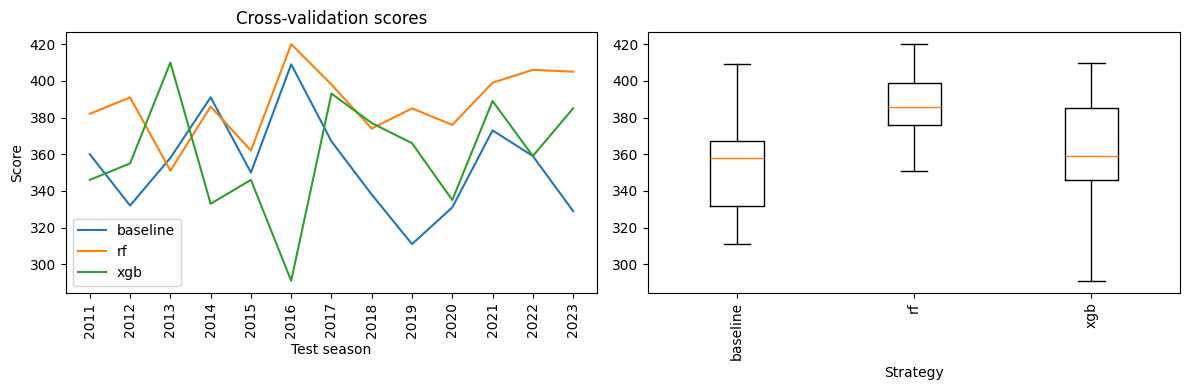

In [163]:

models = {
    "baseline": StaticEstimator([1, 0]),
    "rf": RoundingEstimator(RandomForestRegressor(
        criterion=rf_study.best_params['criterion'], 
        max_depth=rf_study.best_params['max_depth'], 
        n_estimators=rf_study.best_params['n_estimators'], 
        min_samples_split=rf_study.best_params['min_samples_split']
    )),
    "xgb": RoundingEstimator(XGBRegressor(
        n_estimators = xgb_study.best_params["n_estimators"],
        min_child_weight = xgb_study.best_params["min_child_weight"],
        learning_rate = xgb_study.best_params["learning_rate"],
        min_split_loss = xgb_study.best_params["min_split_loss"],
        max_depth = xgb_study.best_params["max_depth"],
        objective=xgb_study.best_params["objective"],
        reg_lambda=xgb_study.best_params["lambda"],
        reg_alpha=xgb_study.best_params["alpha"]
    ))
}

all_scores = []

for model in models.values():
    print(f"Scoring {model}")
    scores = cross_val_score(model, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    all_scores.append(scores)

all_scores = np.array(all_scores)
labels = models.keys()

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
split_test_seasons = [df_matches.iloc[split[1][0]]["leagueSeason"] for  split in splits]
axs[0].plot(all_scores.T, label=labels)
axs[0].set_xticks(range(len(split_test_seasons)), split_test_seasons, rotation=90, ha='center')
axs[0].set_xlabel("Test season")
axs[0].set_ylabel("Score")
axs[0].legend()
axs[0].set_title("Cross-validation scores")

axs[1].boxplot(all_scores.T)
axs[1].set_xlabel("Strategy")
axs[1].set_xticks(range(1, len(labels) +1), labels, rotation=90, ha="center")
fig.tight_layout()
!
